Networks and Word Vectors with MeSH Labels
==========================================

In [1]:
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

In [2]:
import os
import ast
import json
import itertools

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from collections import defaultdict, Counter
from datetime import datetime
from itertools import zip_longest
from matplotlib.ticker import NullFormatter

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, HoverTool

In [3]:
pd.options.display.max_columns = 99

In [4]:
output_notebook()

Loading BokehJS ...

In [5]:
%matplotlib inline

#NB Open a standard set of directories
sep = os.sep
#Paths
#Get the top path
top_path = os.path.dirname(os.getcwd())
#Create the path for external data
ext_data = os.path.join(top_path,'data{s}external{s}'.format(s=sep))
#Raw path (for html downloads)
raw_data = os.path.join(top_path,'data{s}raw{s}'.format(s=sep))
#And external data
proc_data = os.path.join(top_path,'data{s}processed{s}'.format(s=sep))
#And path for figures
fig_path = os.path.join(top_path,'reports{s}figures{s}'.format(s=sep))

#Get date for saving files
today = datetime.utcnow()
today_str = "_".join([str(x) for x in [today.month, today.day, today.year]])

In [6]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [7]:
def column_to_list(df, c):
    return [ast.literal_eval(i) for i in df[c]]

In [8]:
def grouper(n, iterable, fillvalue=None):
    "grouper(3, 'ABCDEFG', 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return zip_longest(fillvalue=fillvalue, *args)

In [9]:
gdb_df = pd.read_csv(proc_data + 'gdb_5_25_2018.csv')

/Users/grichardson/miniconda3/envs/rwjf/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1,5,7,10,11,12,13,14,18,19,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
gdb_df.head()

GH User ID GDB Dataset ID Source ID           Start Date  Status  \
0         NaN            gtr       GDB  2009-04-01 00:00:00  Closed   
1         NaN            gtr       GDB  2009-10-01 00:00:00  Closed   
2         NaN            gtr       GDB  2013-01-01 00:00:00  Closed   
3         NaN            gtr       GDB  2007-12-01 00:00:00  Closed   
4         NaN            gtr       GDB  2005-09-01 00:00:00  Closed   

  GH User Creation Date                                        Description  \
0                   NaN  The past decade has seen a renaissance in acce...   
1                   NaN  Humans and animals are made up of millions of ...   
2                   NaN  Our immune system is vital to protect us from ...   
3                   NaN  Nerve cells communicate through electrical sig...   
4                   NaN  Childhood overweight and obesity is rising rap...   

     Funding                                             Row ID Currency  \
0  2313330.0  http://gtr.rcuk.ac.uk:80/gtr/api/projects/00C9...      GBP   
1  1520860.0  http://gtr.rcuk.ac.uk:80/gtr/api/projects/00E4...      GBP   
2   488548.0  http://gtr.rcuk.ac.uk:80/gtr/api/projects/011C...      GBP   
3   414489.0  http://gtr.rcuk.ac.uk:80/gtr/api/projects/0120...      GBP   
4   156174.0  http://gtr.rcuk.ac.uk:80/gtr/api/projects/0158...      GBP   

  CB Category Group List GH User Type CB Number of Employees CB Category List  \
0                    NaN          NaN                    NaN              NaN   
1                    NaN          NaN                    NaN              NaN   
2                    NaN          NaN                    NaN              NaN   
3                    NaN          NaN                    NaN              NaN   
4                    NaN          NaN                    NaN              NaN   

  CB Role End Date  GH Valid Description                       Name  \
0     NaN      NaN                   NaN  University College London   
1     NaN      NaN                   NaN  University College London   
2     NaN      NaN                   NaN  University College London   
3     NaN      NaN                   NaN  University College London   
4     NaN      NaN                   NaN  University College London   

  administrative_area_level_1 administrative_area_level_2       lng  \
0                     England              Greater London -0.132718   
1                     England              Greater London -0.132718   
2                     England              Greater London -0.132718   
3                     England              Greater London -0.132718   
4                     England              Greater London -0.132718   

         lat         country  doc_id  \
0  51.524469  United Kingdom       0   
1  51.524469  United Kingdom       1   
2  51.524469  United Kingdom       2   
3  51.524469  United Kingdom       3   
4  51.524469  United Kingdom       4   

                                    original_phrases  \
0  ['the UK', 'physics', 'Physics', 'neutron', 'D...   
1  ['Humans', 'animals', 'plasma membrane', 'phos...   
2  ['immune system', 'bacterial', 'innate immunit...   
3  ['Nerve cells', 'action potentials', 'ion chan...   
4  ['Childhood overweight', 'the UK', 'Cohort Stu...   

                                         mesh_labels pub_med_uids  \
0  ['United Kingdom', 'Physics', 'Physics', 'Neut...           []   
1  ['Humans', 'Animals', 'Cell Membrane', 'Phosph...           []   
2  ['Immune System', 'Bacteria', 'Immunity, Innat...           []   
3  ['Neurons', 'Action Potentials', 'Ion Channels...           []   
4  ['Pediatric Obesity', 'United Kingdom', 'Cohor...           []   

                                           mesh_cuis  \
0  ['C0041700', 'C0031837', 'C0031837', 'C0027946...   
1  ['C0086418', 'C0003062', 'C0007603', 'C0031676...   
2  ['C0020962', 'C0004611', 'C0020969', 'C0020962...   
3  ['C0027882', 'C0001272', 'C0022009', 'C0007603...   
4  ['C2362324', 'C0041700', 'C000924

In [11]:
gdb_df = gdb_df[gdb_df['Source ID'] != 'GitHub']
gdb_df = gdb_df[gdb_df['Source ID'] != 'Crunchbase']
gdb_df['Description'][pd.isnull(gdb_df['Description'])] = ''

In [12]:
descriptions = gdb_df['Description'].values

## MeSH Label Exploration

In this section, we explore some properties of the corpus in terms of the MeSH labels that have been assigned to the documents.

In [13]:
description_mesh_labels = [ast.literal_eval(ml) for ml in gdb_df['mesh_labels']]
description_mesh_labels_unique = [list(set(ml)) for ml in description_mesh_labels]

In [14]:
mesh_label_counts = Counter(flatten(description_mesh_labels))
mesh_label_unique_counts = Counter(flatten(description_mesh_labels_unique))

In [15]:
def print_counter_extremes(counter, n=20, low_pass=5, order_low_counts=False):
    most_common = counter.most_common(n)
    low_counts = {k: v for k, v in counter.items() if v <= low_pass}
    low_count_keys_n = list(itertools.islice(low_counts, n))
    low_counts_n = [(k, low_counts[k]) for k in low_count_keys_n]
        
    max_len_high = 0
    max_len_low = 0
    for high, low in zip(most_common, low_counts_n):
        if len(high[0]) > max_len_high:
            max_len_high = len(high[0])
        if len(low[0]) > max_len_low:
            max_len_low = len(low[0])
        
    print('{:<{max_len_high}}\t{}\t{:{max_len_low}}\t{}\n'.format('Label (Common)', 'Count', 'Label (Uncommon)', 'Count',
                                                                  max_len_high=max_len_high + 2,
                                                                  max_len_low=max_len_low + 2))
    for high, low in zip(most_common, low_counts_n):
        print('{:<{max_len_high}}\t{}\t{:{max_len_low}}\t{}'.format(high[0], high[1], low[0], low[1],
                                                         max_len_high=max_len_high + 2,
                                                         max_len_low=max_len_low + 2))
    print('\n')

In [16]:
print('MeSH label counts with duplicates:\n')
print_counter_extremes(mesh_label_counts, 20)

MeSH label counts with duplicates:

Label (Common)                	Count	Label (Uncommon)                         	Count

Humans                        	85848	UBB protein, human                       	1
Students                      	60333	eculizumab                               	3
Animals                       	34520	Apoptosis Regulatory Proteins            	3
Research                      	28156	Hirschsprung Disease                     	2
Goals                         	26820	Tracheostomy                             	2
Universities                  	24713	Tunica Intima                            	5
Research Personnel            	20180	Blood-Nerve Barrier                      	1
United States                 	17038	Chloride Channels                        	1
Female                        	16288	Hepatorenal Syndrome                     	3
Brain                         	16041	In Vivo Dosimetry                        	3
HIV Infections                	13696	Amino Acid Transport System X-A

In [17]:
print('MeSH label counts without duplicates:\n')
print_counter_extremes(mesh_label_unique_counts, 20)

MeSH label counts without duplicates:

Label (Common)              	Count	Label (Uncommon)                          	Count

Humans                      	55666	UBB protein, human                        	1
Goals                       	20401	eculizumab                                	3
Animals                     	18914	Viscera                                   	4
Students                    	14693	Somatoform Disorders                      	5
Universities                	12586	Ischemic Postconditioning                 	1
United States               	11349	Apoptosis Regulatory Proteins             	3
Female                      	11331	Hirschsprung Disease                      	1
Research Personnel          	10046	Enteric Nervous System                    	5
Research                    	9265	Idiopathic Hypogonadotropic Hypogonadism  	3
Child                       	8371	Kallmann Syndrome                         	3
Public Health               	8035	Extremities                               	3

The top labels in our corpus include named groups, research terms, and a few health realated terms. They are all words that could concievably be used in a vast array of contexts. On the other hand, a random display of words with low counts shows many highly specialised labels, including chemical names and particular organisms or anatomical parts.

The next part of this notebook labels each term with its corresponding higher 0th and 1st level group from the MeSH term structure.

In [18]:
description_mesh_duis = [ast.literal_eval(ml) for ml in gdb_df['mesh_duis']]
description_mesh_duis_unique = [list(set(ml)) for ml in description_mesh_duis]

In [19]:
mesh_label_dui_map = {}

for labels, duis in zip(description_mesh_labels_unique, description_mesh_duis_unique):
    for label, dui in zip(labels, duis):
        if label not in mesh_label_dui_map:
            mesh_label_dui_map[label] = dui

In [20]:
with open(proc_data + 'mesh_descriptions_5_29_2018.json', 'r') as f:
    mesh_label_ontology = json.load(f)

In [21]:
dui_tree_number_map = {}

for descriptor in mesh_label_ontology['DescriptorRecordSet']['DescriptorRecord']:
    tree_number = descriptor.get('TreeNumberList')
    if tree_number is not None:
        tree_number = tree_number.get('TreeNumber')
    if isinstance(tree_number, list):
        dui_tree_number_map[descriptor['DescriptorUI']] = tree_number
    else:
        dui_tree_number_map[descriptor['DescriptorUI']] = [tree_number]

In [22]:
tree_level_0_map = {
    'A': 'anatomy',
    'B': 'organisms',
    'C': 'diseases',
    'D': 'chemicals and drugs',
    'E': 'analytical, diagnostic, and therapeutic techniques, and equipment',
    'F': 'psychiatry and psychology',
    'G': 'phenomena and processes',
    'H': 'disciplines and occupations',
    'I': 'anthropology, education, sociology, and social phenomena',
    'J': 'technology, industry, and agriculture',
    'K': 'humanities',
    'L': 'information science',
    'M': 'named groups',
    'N': 'health care',
    'V': 'publication characteristics',
    'Z': 'geographicals'
}

In [24]:
tree_level_1_map = {}

for descriptor in mesh_label_ontology['DescriptorRecordSet']['DescriptorRecord']:
    tree_number = descriptor.get('TreeNumberList')
    descriptor_name = descriptor.get('DescriptorName')
    descriptor_name = descriptor_name['String']
    if tree_number is not None:
        tree_number = tree_number.get('TreeNumber')
        if isinstance(tree_number, str):
            if len(tree_number.split('.')) == 1:
                tree_level_1_map[tree_number] = descriptor_name

In [25]:
mesh_label_nodes = list(mesh_label_counts.keys())

In [27]:
n_mesh_labels = len(flatten(description_mesh_labels))
n_mesh_labels_unique = len(flatten(description_mesh_labels_unique))

In [29]:
def map_tree_group(label, label_dui_map, dui_tree_number_map, tree_map, level=1):
    dui = label_dui_map.get(label)
    groups = []
    if dui is not None:
        tree_numbers = dui_tree_number_map.get(dui)
        if tree_numbers is not None:
            for tn in tree_numbers:
                if tn is not None:
                    tn = tn.split('.')
                    if level == 0:
                        tn = tn[0][0]
                    elif level == 1:
                        tn = tn[0]
                    else:
                        tn = '.'.join(tn[:level - 1])
                    group = tree_map.get(tn)
                    if group is not None:
                        groups.append(group)
    if len(groups) > 0:
        return list(set(groups))
    else:
        return ['Other']

## Term Graph

We now have a series of documents described in terms of their MeSH labels. From this we can build a network to explore the connections between concepts, and try to understand how we might be able to find "innovative" combinations or terms in an unsupervised manner. For this network, nodes will be the terms themselves, while an edge being drawn between two nodes will represent that term pair appearing in at least one document together - a coocurrence.

- Node attributes:
    - count: total number of times the term appeared in the corpus (int)
    - count_normalised: count, normalised by the total number of terms in the corpus (float)
    - mesh_tree_codes: array of MeSH Tree Numbers (list)
    - edge_count: number of other nodes that this node is connected to (int)

In [30]:
graph_mesh_labels = nx.Graph()

In [31]:
for mln in mesh_label_nodes:
    count = mesh_label_unique_counts[mln]
    graph_mesh_labels.add_node(
        mln,
        count=count,
        count_normalised=count / n_mesh_labels_unique,
        group_0=map_tree_group(
            mln, 
            mesh_label_dui_map, 
            dui_tree_number_map, 
            tree_level_0_map,
            level=0
        ),
        group_1=map_tree_group(
            mln, 
            mesh_label_dui_map, 
            dui_tree_number_map, 
            tree_level_1_map
        )
    )

Each node is connected to another node by an edge when they coocurr in at least one document. However, this provides no information about how often different labels coocurr with each other. To account for this, we will provide a choice of weights for the edges. The first is the raw number of coocurrences across the corpus. We then also calculate the Jaccard index and the association strength as defined in Waltman _et al_.  2009 and Noyons _et al_. 2010 respectively.

- Edge attributes
    - weight_absolute: number of documents in which terms coocur (int)
    - jaccard_similarity: number between 0 and 1 representing the Jaccard Index of terms (float)
    - association_strength: association strength score of terms (float)

In [33]:
description_mesh_label_combinations = []
for ml in description_mesh_labels_unique:
    mesh_label_doc = list(itertools.combinations(set(ml), r=2))
    mesh_label_doc = [tuple(sorted(mld)) for mld in mesh_label_doc]
    description_mesh_label_combinations.append(mesh_label_doc)

In [34]:
edge_coocurrence_counts = Counter(flatten(description_mesh_label_combinations))

In [35]:
mesh_label_coocurrence_count_map = defaultdict(dict)

for ml, c in edge_coocurrence_counts.items():
    n0 = ml[0]
    n1 = ml[1]
    mesh_label_coocurrence_count_map[n0][n1] = c
    mesh_label_coocurrence_count_map[n1][n0] = c

In [36]:
n_coocurrences = len(flatten(description_mesh_label_combinations))
n_edges = len(edge_coocurrence_counts)

In [37]:
print('Number of Co-occurrences:', n_coocurrences)
print('Number of Edges:', n_edges)
print('Mean Co-occurences per Edge:', n_coocurrences / n_edges)

Number of Co-occurrences: 8969934
Number of Edges: 2392740
Mean Co-occurences per Edge: 3.7488126582913313


In [38]:
mesh_label_coocurrence_counts = {}
mesh_label_edge_counts = {}

for ml, co in mesh_label_coocurrence_count_map.items():
    coocurrence_count = sum([n for n in co.values()])
    edge_count = len(co)
    mesh_label_edge_counts[ml] = edge_count
    mesh_label_coocurrence_counts[ml] = coocurrence_count

mesh_label_coocurrence_counts = Counter(mesh_label_coocurrence_counts)
mesh_label_edge_counts = Counter(mesh_label_edge_counts)

In [39]:
print_counter_extremes(mesh_label_coocurrence_counts)

Label (Common)              	Count	Label (Uncommon)                             	Count

Humans                      	731663	Nicotinamide-Nucleotide Adenylyltransferase  	5
Animals                     	280776	UDPglucose 4-Epimerase                       	4
Goals                       	275433	Encephalitozoon cuniculi                     	4
Students                    	206706	Specialties, Dental                          	2
Universities                	175459	Anesthetics, Inhalation                      	3
Female                      	170062	Fluoroacetates                               	5
United States               	159346	N-Nitrosopyrrolidine                         	4
Research Personnel          	136980	Familial Primary Pulmonary Hypertension      	2
Child                       	123669	Antimony Potassium Tartrate                  	5
Research                    	114141	Strongylida Infections                       	4
Public Health               	114031	Angiostrongylus cantonensis         

In [40]:
print_counter_extremes(mesh_label_edge_counts)

Label (Common)      	Count	Label (Uncommon)                             	Count

Humans              	18192	Nicotinamide-Nucleotide Adenylyltransferase  	5
Animals             	14364	UDPglucose 4-Epimerase                       	4
Goals               	13367	Encephalitozoon cuniculi                     	4
Students            	11721	Specialties, Dental                          	2
Female              	11150	Anesthetics, Inhalation                      	3
Universities        	10630	Fluoroacetates                               	5
United States       	10599	N-Nitrosopyrrolidine                         	4
Research Personnel  	9747	Familial Primary Pulmonary Hypertension      	2
Child               	8943	Antimony Potassium Tartrate                  	5
Research            	8817	Strongylida Infections                       	4
Public Health       	8592	Angiostrongylus cantonensis                  	4
Male                	8400	Antazoline                                   	5
Mice                	7763

In [41]:
def jaccard_similarity(term_0, term_1, n):
    return n / (mesh_label_unique_counts[term_0] + mesh_label_unique_counts[term_1] - n)

In [42]:
def edge_association_strength(term_0, term_1, n):
    return (2 * n_edges * n) / (mesh_label_edge_counts[term_0] * mesh_label_edge_counts[term_1])

def coocurrence_association_strength(term_0, term_1, n):
    return (2 * n_coocurrences * n) / (mesh_label_coocurrence_counts[term_0] * mesh_label_coocurrence_counts[term_1])

In [43]:
for edge, count in edge_coocurrence_counts.items():
    node_0 = edge[0]
    node_1 = edge[1]
    graph_mesh_labels.add_edge(node_0, node_1,
                               coocurrences_absolute=count,
                               jaccard_similarity=jaccard_similarity(node_0,
                                                                     node_1,
                                                                     count),
                               association_strength=coocurrence_association_strength(node_0,
                                                                                     node_1,
                                                                                     count))

In [44]:
with open(proc_data + 'mesh_term_raw_graph.json', 'w') as f:
    json.dump(nx.node_link_data(graph_mesh_labels), f)

Let's have a look at the edge attributes for the most common and some of the least common coocurrences.

In [45]:
top_n = 20

print('{:<30}\t{:<8}\t{:30}\t{:<8}\t{:<15}\t{}\t{}\n'.format(
    'Node 0', 'Count 0', 'Node 1', 'Count 1', 'Cooccurences',
    'Jaccard Index', 'Association Strength'))

for l, n in edge_coocurrence_counts.most_common(top_n):
    term_0 = l[0]
    term_1 = l[1]
    c0 = mesh_label_unique_counts[term_0]
    c1 = mesh_label_unique_counts[term_1]
    j = jaccard_similarity(term_0, term_1, n)
    a = coocurrence_association_strength(term_0, term_1, n)
    print('{:<30}\t{:<8}\t{:30}\t{:<8}\t{:<15}\t{:.2f}\t{:12.2f}'.format(l[0], c0, l[1], c1, n, j, a))
    
print('...')

low_counts = {k: v for k, v in edge_coocurrence_counts.items() if v <= 3}
low_count_keys_n = list(itertools.islice(low_counts, top_n))
low_counts_n = [(k, low_counts[k]) for k in low_count_keys_n]

for l, n in low_counts_n:
    term_0 = l[0]
    term_1 = l[1]
    c0 = mesh_label_unique_counts[term_0]
    c1 = mesh_label_unique_counts[term_1]
    j = jaccard_similarity(term_0, term_1, n)
    a = coocurrence_association_strength(term_0, term_1, n)
    print('{:<30}\t{:8}\t{:30}\t{:<8}\t{:<15}\t{:.2f}\t{:12.2f}'.format(l[0], c0, l[1], c1, n, j, a))

print('\n')

Node 0                        	Count 0 	Node 1                        	Count 1 	Cooccurences   	Jaccard Index	Association Strength

Goals                         	20401   	Humans                        	55666   	12631          	0.20	        1.12
Animals                       	18914   	Humans                        	55666   	10458          	0.16	        0.91
Female                        	11331   	Humans                        	55666   	9209           	0.16	        1.33
Child                         	8371    	Humans                        	55666   	8364           	0.15	        1.66
Humans                        	55666   	Students                      	14693   	7959           	0.13	        0.94
Humans                        	55666   	United States                 	11349   	7454           	0.13	        1.15
Humans                        	55666   	Universities                  	12586   	6886           	0.11	        0.96
Humans                        	55666   	Research Personnel            

We can see that edges representing high numbers of coocurrences are unsurprisingly drawn between terms that have a high count across the corpus. Interestingly, the terms with the highest number of coocurrences are not the two that have the highest frequency (_Humans_ and _Students_). We can see that for the top terms, the Jaccard similarity hovers at the lower end of the range. We can see how it is modulated by both the number of coocurrences, but also the individual term frequencies. At the lower end of the coocurrence counts, we can see connected terms that exhibit a Jaccard index of only 0.01 or less. The association strength however shows a large degree of variation, in part due to its inherent nature of not being bounded between finite limits. The range of values among the most highly occurring terms and the less frequent terms are more consistent too. However, it can be seen that terms with lower frequencies can exhibit much higher association strengths, as their low counts reduces the chances of them coocurring "by chance".

### Parsing the Documents

To understand the nature of the terms in the network and their relationships with the documents, we need to extract quantitative information aobut the documents. Here we parse the corpus, using _spaCy_.

In [46]:
import spacy

In [47]:
nlp = spacy.load('en_core_web_sm')
tokenizer = nlp.tokenizer

In [48]:
nlp.pipe_names

['tagger', 'parser', 'ner']

In [49]:
# nlp.remove_pipe('ner')

In [50]:
with open('../data/external/en_ranknl_long.txt', 'r') as f:
    text = f.read()
stop_words = text.split('\n')

In [51]:
for stop in stop_words:
    nlp.vocab[stop].is_stop = True
    nlp.vocab[stop.title()].is_stop = True
    nlp.vocab[stop.upper()].is_stop = True

Textacy allows us to build a corpus where each document has attributes, such as the document ID. This is useful if we want to match up documents with other fields in the DataFrame later.

In [52]:
import textacy

In [53]:
meta = gdb_df[['doc_id', 'mesh_labels', 'country']].to_dict(orient='records')

In [54]:
descriptions_tokenized = [tokenizer(d) for d in descriptions]

In [55]:
# %time corpus_descriptions = textacy.Corpus(lang=tokenizer, texts=descriptions[:10], metadatas=meta[:10])

## Visual Exploration

In this section, we plot and describe characteristics of the MeSH labels and the documents.

#### Plotting Functions

In [71]:
def pdf_cdf(ax, x, bins, normed=False, stats=True):
    
    v = plt.get_cmap('viridis')
    pdf_c = v.colors[0]
    cdf_c = v.colors[90]
    mean_c = v.colors[180]
    med_c = v.colors[230]
    
    xmax = np.max(x)
    xmin = np.min(x)

    pdf, bin_edges = np.histogram(x, bins)
    cdf = np.cumsum(pdf / np.sum(pdf))
    if normed:
        ax.set_ylabel('Probability')
        ax.bar(bin_edges[:-1], pdf / np.sum(pdf), np.diff(bin_edges), color=pdf_c)
    else:
        ax.set_ylabel('Frequency')
        ax.bar(bin_edges[:-1], pdf, np.diff(bin_edges), color=pdf_c)
    if stats:
        mean = np.mean(x)
        median = np.median(x)
        ax.axvline(mean, color=mean_c, linestyle='--', linewidth=3, label='Mean: {:.2f}'.format(mean), alpha=0.7)
        ax.axvline(median, color=med_c, linestyle='--', linewidth=3, label='Median: {:.2f}'.format(median), alpha=0.7)
        ax.legend()
    ax.set_xlim((np.min(bin_edges), np.max(bin_edges)))
    ax_cdf = ax.twinx()
    ax_cdf.plot(bin_edges[:-1], cdf, color=cdf_c, linewidth=4, alpha=0.8)
    ax_cdf.set_ylabel('Cumulative')
    ax_cdf.set_ylim((0, 1))
    ax_cdf.tick_params('y')
    return ax, ax_cdf
    
def pdf_cdf_h(ax, y, bins, normed=False, stats=True):
    v = plt.get_cmap('viridis')
    pdf_c = v.colors[0]
    cdf_c = v.colors[90]
    mean_c = v.colors[180]
    med_c = v.colors[230]
    
    xmax = np.max(y)
    xmin = np.min(y)

    pdf, bin_edges = np.histogram(y, bins)
    cdf = np.cumsum(pdf / np.sum(pdf))
    if normed:
        ax.set_xlabel('Probability')
        ax.barh(bin_edges[:-1], pdf / np.sum(pdf), np.diff(bin_edges), color=pdf_c)
    else:
        ax.set_xlabel('Frequency')
        ax.barh(bin_edges[:-1], pdf, np.diff(bin_edges), color=pdf_c)
    if stats:
        mean = np.mean(y)
        median = np.median(y)
        ax.axhline(mean, color=mean_c, linestyle='--', linewidth=3, label='Mean: {:.2f}'.format(mean), alpha=0.7)
        ax.axhline(median, color=med_c, linestyle='--', linewidth=3, label='Median: {:.2f}'.format(median), alpha=0.7)
        ax.legend()
    ax.set_ylim((np.min(bin_edges), np.max(bin_edges)))
    ax_cdf = ax.twiny()
    ax_cdf.plot(cdf, bin_edges[:-1], color=cdf_c, linewidth=4, alpha=0.8)
    ax_cdf.set_xlabel('Cumulative')
    ax_cdf.set_xlim((0, 1))
    ax_cdf.tick_params('y')
    return ax, ax_cdf

In [72]:
def hexbin_sidegrams(x, y, hb_bins=None, hb_gridsize=50, hb_mincnt=1, hb_xlabel='', 
                     title='', hb_ylabel='', cb_label='', 
                     th_bins=100, th_norm=False, th_stats=True,
                     lh_bins=100, lh_norm=False, lh_stats=True):

    nullfmt = NullFormatter()         # no labels

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    # start with a rectangular Figure
    plt.figure(1, figsize=(14, 8))

    ax_hb = plt.axes(rect_scatter)
    ax_hist_x = plt.axes(rect_histx)
    ax_hist_y = plt.axes(rect_histy)
    cbaxes = plt.axes([0, 0.1, 0.02, 0.65])

    # no labels
    ax_hist_x.xaxis.set_major_formatter(nullfmt)
    ax_hist_y.yaxis.set_major_formatter(nullfmt)

    hb = ax_hb.hexbin(x, y, bins=hb_bins, gridsize=hb_gridsize, cmap='viridis', mincnt=hb_mincnt)
    ax_hb.axis([np.min(x), np.max(x), np.min(y), np.max(y)])
    cb = plt.colorbar(hb, cax = cbaxes)
    cb.set_label(cb_label)
    cb.ax.yaxis.set_ticks_position('left')
    cb.ax.yaxis.set_label_position('left')

    # now determine nice limits
    xmax = np.max(x[~np.isinf(x)])
    xmin = np.min(x[~np.isinf(x)])
    ymax = np.max(y[~np.isinf(y)])
    ymin = np.min(y[~np.isinf(y)])

    ax_hb.set_xlim((xmin, xmax))
    ax_hb.set_ylim((ymin, ymax))
    ax_hb.set_xlabel(hb_xlabel)
    ax_hb.set_ylabel(hb_ylabel)
    
    ax_hist_x, ax_hist_cum_x = pdf_cdf(ax_hist_x, x, th_bins, normed=th_norm, stats=th_stats)

    ax_hist_y, ax_hist_cum_y = pdf_cdf_h(ax_hist_y, y, lh_bins, normed=lh_norm, stats=lh_stats)

    ax_hist_x.set_xlim(ax_hb.get_xlim())
    ax_hist_y.set_ylim(ax_hb.get_ylim())
    
#     labels = ax_hist_cum_x.get_yticklabels()
#     labels[0] = ''
#     ax_hist_cum_x.set_yticklabels(labels)
    plt.setp(ax_hist_cum_x.get_yticklabels()[0], visible=False)
    plt.setp(ax_hist_cum_y.get_xticklabels()[0], visible=False)

    ax_hist_x.set_title(title)

In [73]:
def scatter_sidegrams(x, y, title='', sc_ylabel='', sc_xlabel='',
                     th_bins=100, th_norm=False, th_stats=True,
                     lh_bins=100, lh_norm=False, lh_stats=True,
                     **sc_kwargs):

    nullfmt = NullFormatter()         # no labels

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    # start with a rectangular Figure
    plt.figure(1, figsize=(14, 8))

    ax_sc = plt.axes(rect_scatter)
    ax_hist_x = plt.axes(rect_histx)
    ax_hist_y = plt.axes(rect_histy)

    # no labels
    ax_hist_x.xaxis.set_major_formatter(nullfmt)
    ax_hist_y.yaxis.set_major_formatter(nullfmt)

    sc = ax_sc.scatter(x, y, **sc_kwargs)
    ax_sc.axis([np.min(x), np.max(x), np.min(y), np.max(y)])

    # now determine nice limits
    xmax = np.max(x)
    xmin = np.min(x)
    ymax = np.max(y)
    ymin = np.min(y)

    ax_sc.set_xlim((xmin, xmax))
    ax_sc.set_ylim((ymin, ymax))
    ax_sc.set_xlabel(sc_xlabel)
    ax_sc.set_ylabel(sc_ylabel)
    
    ax_hist_x, ax_hist_cum_x = pdf_cdf(ax_hist_x, x, th_bins, normed=th_norm, stats=th_stats)

    ax_hist_y, ax_hist_cum_y = pdf_cdf_h(ax_hist_y, y, lh_bins, normed=lh_norm, stats=lh_stats)

    ax_hist_x.set_xlim(ax_sc.get_xlim())
    ax_hist_y.set_ylim(ax_sc.get_ylim())
    
    plt.setp(ax_hist_cum_x.get_yticklabels()[0], visible=False)
    plt.setp(ax_hist_cum_y.get_xticklabels()[0], visible=False)

    ax_hist_x.set_title(title)

In [59]:
def colour_scatter_sidegrams(x, y, c, cmap='viridis', title='', sc_ylabel='', sc_xlabel='',
                     th_bins=100, th_norm=False, th_stats=True,
                     lh_bins=100, lh_norm=False, lh_stats=True,
                     **sc_kwargs):

    nullfmt = NullFormatter()         # no labels

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    # start with a rectangular Figure
    plt.figure(1, figsize=(14, 8))

    ax_sc = plt.axes(rect_scatter)
    ax_hist_x = plt.axes(rect_histx)
    ax_hist_y = plt.axes(rect_histy)

    # no labels
    ax_hist_x.xaxis.set_major_formatter(nullfmt)
    ax_hist_y.yaxis.set_major_formatter(nullfmt)

    sc = ax_sc.scatter(x, y, c, cmap=cmap, **sc_kwargs)
    ax_sc.axis([np.min(x), np.max(x), np.min(y), np.max(y)])

    # now determine nice limits
    xmax = np.max(x)
    xmin = np.min(x)
    ymax = np.max(y)
    ymin = np.min(y)

    ax_sc.set_xlim((xmin, xmax))
    ax_sc.set_ylim((ymin, ymax))
    ax_sc.set_xlabel(sc_xlabel)
    ax_sc.set_ylabel(sc_ylabel)
    
    ax_hist_x, ax_hist_cum_x = pdf_cdf(ax_hist_x, x, th_bins, normed=th_norm, stats=th_stats)

    ax_hist_y, ax_hist_cum_y = pdf_cdf_h(ax_hist_y, y, lh_bins, normed=lh_norm, stats=lh_stats)

    ax_hist_x.set_xlim(ax_sc.get_xlim())
    ax_hist_y.set_ylim(ax_sc.get_ylim())
    
    plt.setp(ax_hist_cum_x.get_yticklabels()[0], visible=False)
    plt.setp(ax_hist_cum_y.get_xticklabels()[0], visible=False)

    ax_hist_x.set_title(title)

### Terms

In [60]:
terms_df = pd.DataFrame({'terms': list(mesh_label_unique_counts.keys())})

terms_df['occurrences'] = terms_df['terms'].map(mesh_label_unique_counts)
terms_df['cooccurrences'] = terms_df['terms'].map(mesh_label_coocurrence_counts)
terms_df['edges'] = terms_df['terms'].map(mesh_label_edge_counts)
terms_df['occurrences_log'] = np.log10(terms_df['occurrences'])
terms_df['cooccurrences_log'] = np.log10(terms_df['cooccurrences'])
terms_df['edges_log'] = np.log10(terms_df['edges'])

/Users/grichardson/miniconda3/envs/rwjf/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/Users/grichardson/miniconda3/envs/rwjf/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


In [64]:
terms_df.head()

terms  occurrences  cooccurrences  edges  occurrences_log  \
0  Radioactive Waste          115           1628    489         2.060698   
1            Protons          295           3802   1192         2.469822   
2       Universities        12586         175459  10630         4.099888   
3           Students        14693         206706  11721         4.167110   
4           Neutrons          233           2911    889         2.367356   

   cooccurrences_log  edges_log  cooccurrences_per_occurrence  \
0           3.211654   2.689309                     14.156522   
1           3.580012   3.076276                     12.888136   
2           5.244176   4.026533                     13.940807   
3           5.315353   4.068965                     14.068332   
4           3.464042   2.948902                     12.493562   

   edges_per_occurrence  
0              4.252174  
1              4.040678  
2              0.844589  
3              0.797727  
4              3.815451

In [65]:
terms_df['cooccurrences_per_occurrence'] = terms_df['cooccurrences'] / terms_df['occurrences']
terms_df['edges_per_occurrence'] = terms_df['edges'] / terms_df['occurrences']

In [66]:
def get_valid_arrays(df, col_0, col_1):
    sub_df = df[[col_0, col_1]]
    sub_df = sub_df.replace([np.inf, -np.inf], np.nan)
    sub_df = sub_df[((~pd.isnull(sub_df[col_0])) & (~pd.isnull(sub_df[col_1])))]
    arr_0 = sub_df[col_0]
    arr_1 = sub_df[col_1]
    return arr_0, arr_1

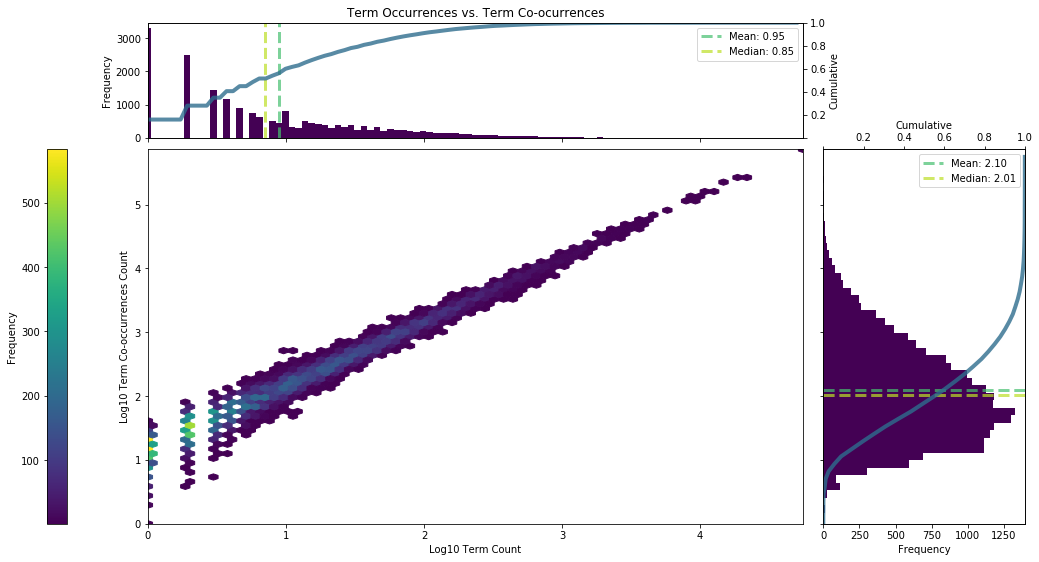

In [74]:
term_occurrences_arr, term_cooccurrences_arr = get_valid_arrays(terms_df, 'occurrences_log', 'cooccurrences_log')

hexbin_sidegrams(term_occurrences_arr, term_cooccurrences_arr,
                 hb_gridsize=70,
                 hb_xlabel='Log10 Term Count',
                 hb_ylabel='Log10 Term Co-occurrences Count',
                 title='Term Occurrences vs. Term Co-ocurrences', 
                 cb_label='Frequency',
                 lh_bins=50)

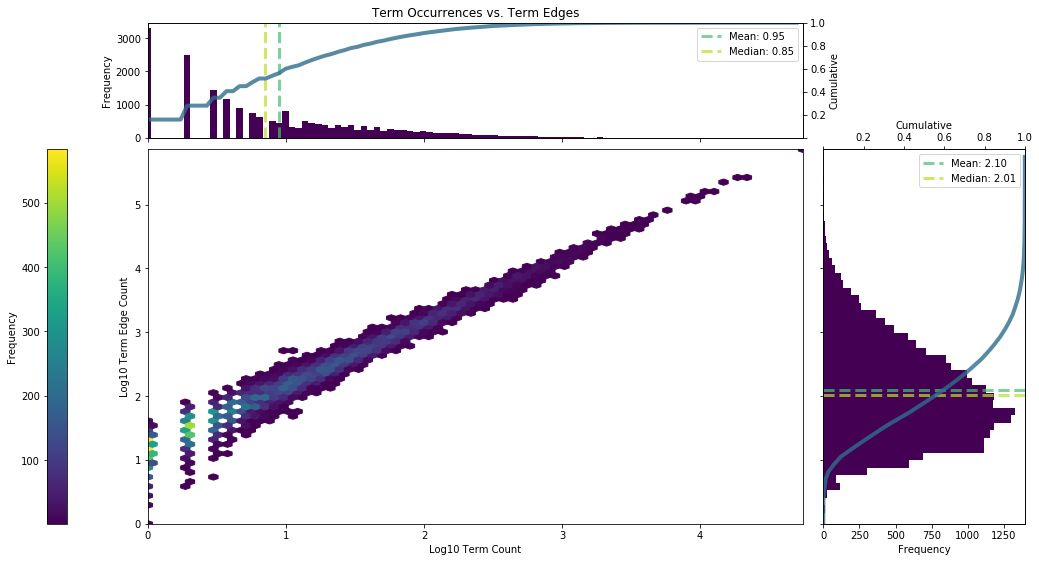

In [75]:
term_occurrences_arr, term_edges_arr = get_valid_arrays(terms_df, 'occurrences_log', 'edges_log')

hexbin_sidegrams(term_occurrences_arr, term_cooccurrences_arr,
                 hb_gridsize=70,
                 hb_xlabel='Log10 Term Count',
                 hb_ylabel='Log10 Term Edge Count',
                 title='Term Occurrences vs. Term Edges', 
                 cb_label='Frequency',
                 lh_bins=50)

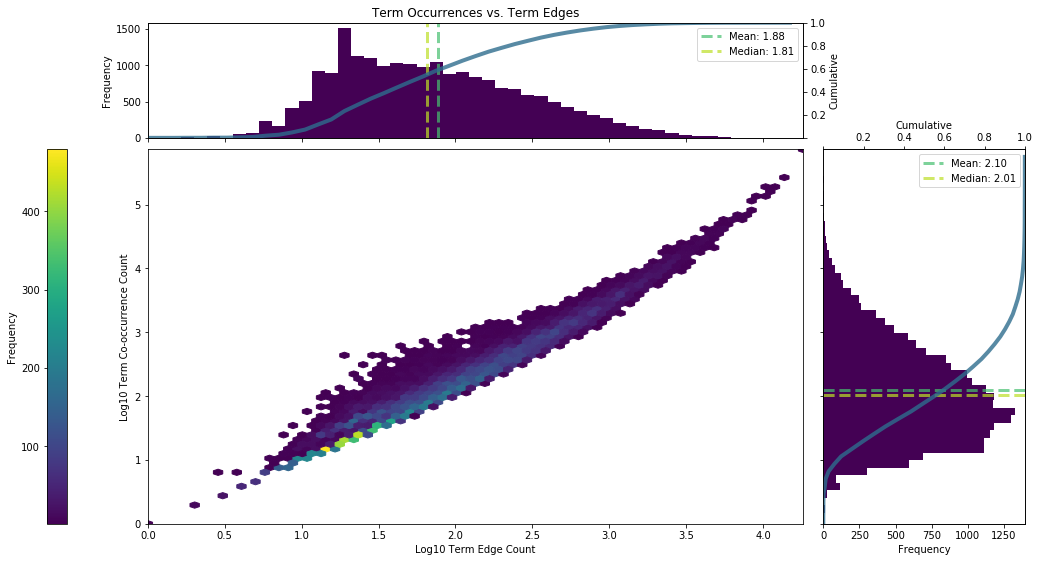

In [76]:
hexbin_sidegrams(term_edges_arr, term_cooccurrences_arr,
                 hb_gridsize=70,
                 hb_xlabel='Log10 Term Edge Count',
                 hb_ylabel='Log10 Term Co-occurrence Count',
                 title='Term Occurrences vs. Term Edges', 
                 cb_label='Frequency',
                 lh_bins=50,
                 th_bins=50)

In [82]:
l_mesh_labels_unique = list(set(flatten(description_mesh_labels_unique)))

In [83]:
term_association_strengths_dict = defaultdict(list)

for l, n in edge_coocurrence_counts.items():
    term_0 = l[0]
    term_1 = l[1]
    assoc_str = coocurrence_association_strength(term_0, term_1, n)
    term_association_strengths_dict[term_0].append(assoc_str)
    term_association_strengths_dict[term_1].append(assoc_str)

In [84]:
term_mean_assoc_strengths = {}
term_std_assoc_strengths = {}
term_med_assoc_strengths = {}
term_min_assoc_strengths = {}
term_max_assoc_strengths = {}

for t, a_s in term_association_strengths_dict.items():
    term_mean_assoc_strengths[t] = np.mean(a_s)
    term_std_assoc_strengths[t] = np.std(a_s)
    term_med_assoc_strengths[t] = np.median(a_s)
    term_min_assoc_strengths[t] = np.min(a_s)
    term_max_assoc_strengths[t] = np.max(a_s)
    
terms_df['mean_assoc_strength'] = terms_df['terms'].map(term_mean_assoc_strengths)
terms_df['median_assoc_strength'] = terms_df['terms'].map(term_med_assoc_strengths)
terms_df['std_assoc_strength'] = terms_df['terms'].map(term_std_assoc_strengths)
terms_df['min_assoc_strength'] = terms_df['terms'].map(term_min_assoc_strengths)
terms_df['max_assoc_strength'] = terms_df['terms'].map(term_max_assoc_strengths)
terms_df['mean_assoc_strength_log'] = np.log10(terms_df['mean_assoc_strength'])
terms_df['median_assoc_strength_log'] = np.log10(terms_df['median_assoc_strength'])
terms_df['std_assoc_strength_log'] = np.log10(terms_df['std_assoc_strength'])
terms_df['min_assoc_strength_log'] = np.log(terms_df['min_assoc_strength'])
terms_df['max_assoc_strength_log'] = np.log(terms_df['max_assoc_strength'])

/Users/grichardson/miniconda3/envs/rwjf/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


In [85]:
terms_df.describe()

occurrences  cooccurrences         edges  occurrences_log  \
count  20720.000000   20720.000000  20720.000000     20720.000000   
mean      60.395029     865.823745    230.959459         0.951293   
std      522.507570    7119.775600    551.296187         0.742732   
min        1.000000       0.000000      0.000000         0.000000   
25%        2.000000      33.000000     25.000000         0.301030   
50%        7.000000     103.000000     65.000000         0.845098   
75%       27.000000     396.000000    201.250000         1.431364   
max    55666.000000  731663.000000  18192.000000         4.745590   

       cooccurrences_log     edges_log  cooccurrences_per_occurrence  \
count       2.072000e+04  2.072000e+04                  20720.000000   
mean                -inf          -inf                     14.871137   
std                  NaN           NaN                      4.610367   
min                 -inf          -inf                      0.000000   
25%         1.518514e+00  1.397940e+00                     11.944902   
50%         2.012837e+00  1.812913e+00                     14.400000   
75%         2.597695e+00  2.303735e+00                     17.200000   
max         5.864311e+00  4.259880e+00                     49.200000   

       edges_per_occurrence  mean_assoc_strength  median_assoc_strength  \
count          20720.000000         2.071600e+04           2.071600e+04   
mean               9.602010         1.849514e+03           3.854001e+02   
std                4.721216         2.365302e+04           2.128833e+04   
min                0.000000         1.186860e+00           1.089485e+00   
25%                6.478540         9.954956e+01           1.564109e+01   
50%                8.739130         3.305314e+02           4.637326e+01   
75%               11.600000         1.041767e+03           1.348246e+02   
max               40.000000         2.989978e+06           2.989978e+06   

       std_assoc_strength  min_assoc_strength  max_assoc_strength  \
count        2.071600e+04        2.071600e+04        2.071600e+04   
mean         3.625550e+03        1.581468e+02        1.406939e+04   
std          1.861534e+04        2.079368e+04        5.184653e+04   
min          0.000000e+00        1.434968e-02        1.735786e+01   
25%          2.662303e+02        2.993590e-01        1.980009e+03   
50%          8.063067e+02        6.870310e-01        4.836685e+03   
75%          2.465711e+03        1.401103e+00        1.205636e+04   
max          1.112894e+06        2.989978e+06        2.989978e+06   

       mean_assoc_strength_log  median_assoc_strength_log  \
count             20716.000000               20716.000000   
mean                  2.515937                   1.680199   
std                   0.751214                   0.664745   
min                   0.074400                   0.037221   
25%                   1.998039                   1.194267   
50%                   2.519213                   1.666268   
75%                   3.017771                   2.129769   
max                   6.475668                   6.475668   

       std_assoc_strength_log  min_assoc_strength_log  max_assoc_strength_log  
count            2.071600e+04            20716.000000            20716.000000  
mean                     -inf               -0.348294                8.511348  
std                       NaN                1.365840                1.370348  
min                      -inf               -4.244028                2.854045  
25%              2.425258e+00               -1.206112                7.590856  
50%              2.906500e+00               -0.375376                8.483985  
75%              3.391942e+00                0.337260                9.397348  
max              6.046454e+00               14.910777               14.910777

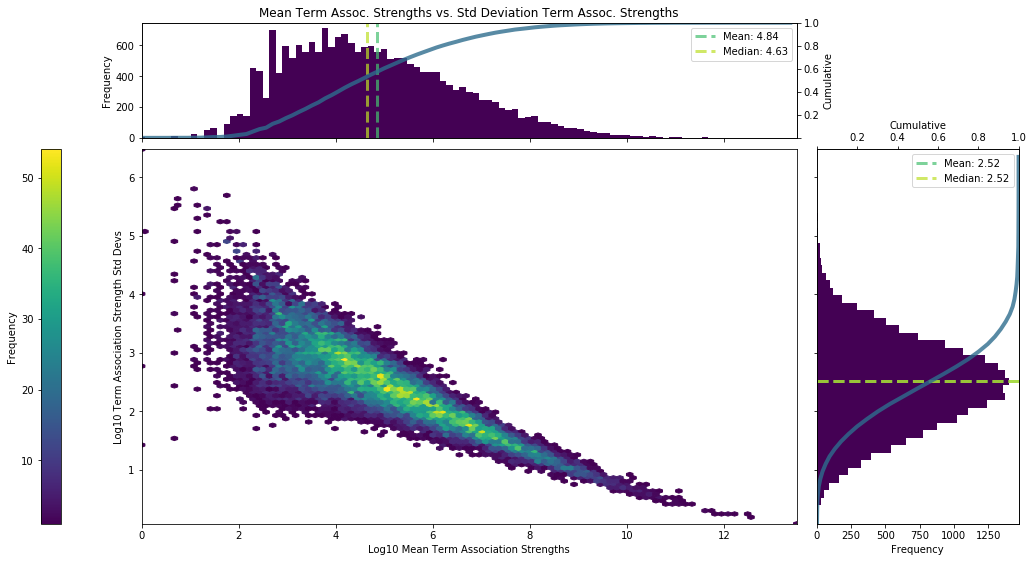

In [86]:
cooccurrences, mean_assoc_strengths = get_valid_arrays(terms_df, 'cooccurrences', 'mean_assoc_strength_log')

hexbin_sidegrams(np.log(cooccurrences), mean_assoc_strengths,
                 hb_xlabel='Log10 Mean Term Association Strengths',
                 hb_ylabel='Log10 Term Association Strength Std Devs',
                 title='Mean Term Assoc. Strengths vs. Std Deviation Term Assoc. Strengths', 
                 cb_label='Frequency',
                 hb_gridsize=100,
                 lh_bins=50)

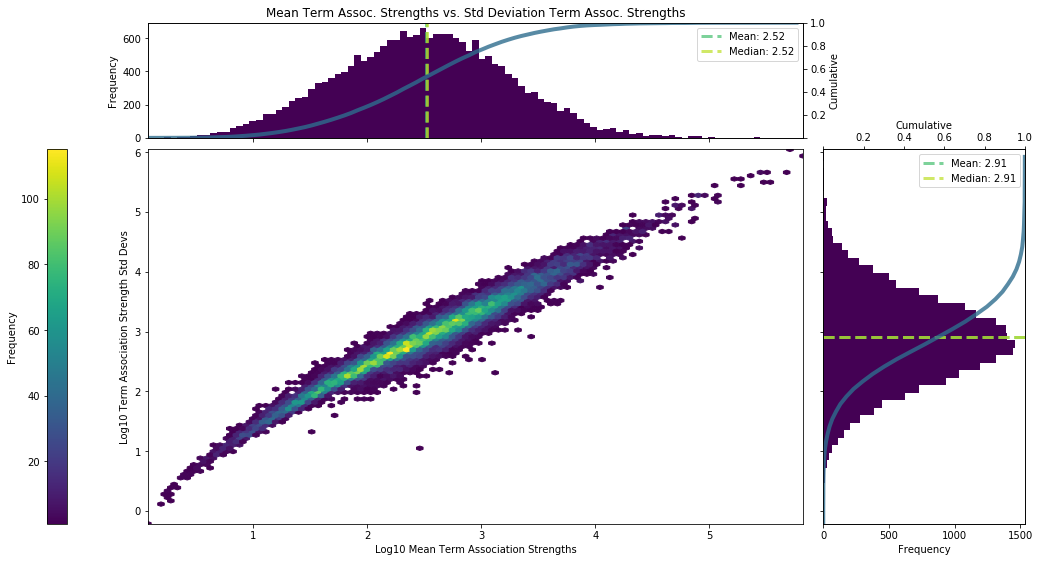

In [87]:
mean_assoc_strengths, std_assoc_strengths = get_valid_arrays(terms_df, 'mean_assoc_strength_log', 'std_assoc_strength_log')

hexbin_sidegrams(mean_assoc_strengths, std_assoc_strengths,
                 hb_xlabel='Log10 Mean Term Association Strengths',
                 hb_ylabel='Log10 Term Association Strength Std Devs',
                 title='Mean Term Assoc. Strengths vs. Std Deviation Term Assoc. Strengths', 
                 cb_label='Frequency',
                 hb_gridsize=100,
                 lh_bins=50)

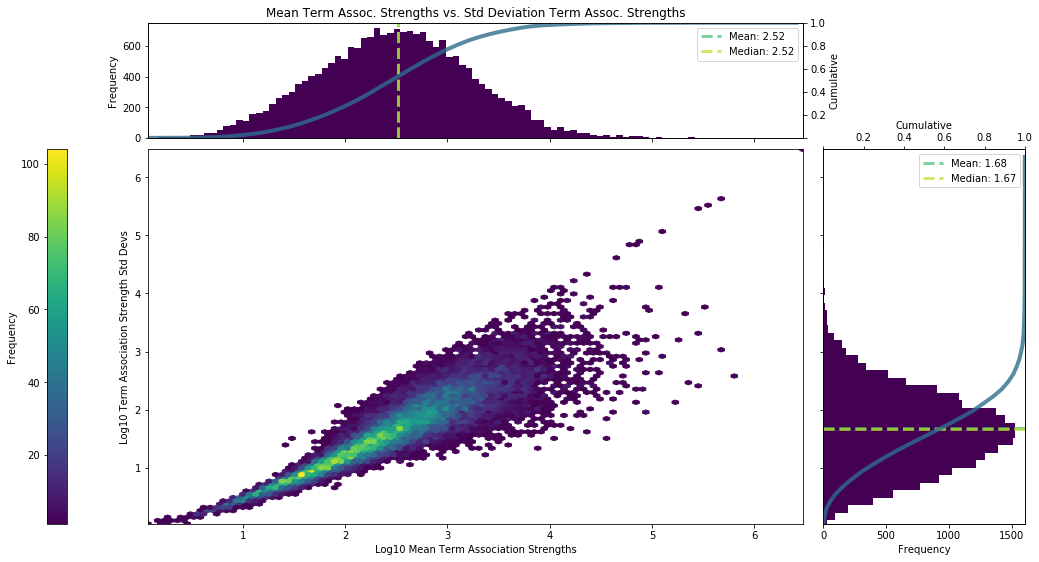

In [88]:
mean_assoc_strengths, med_assoc_strengths = get_valid_arrays(terms_df, 'mean_assoc_strength_log', 'median_assoc_strength_log')

hexbin_sidegrams(mean_assoc_strengths, med_assoc_strengths,
                 hb_xlabel='Log10 Mean Term Association Strengths',
                 hb_ylabel='Log10 Term Association Strength Std Devs',
                 title='Mean Term Assoc. Strengths vs. Std Deviation Term Assoc. Strengths', 
                 cb_label='Frequency',
                 hb_gridsize=100,
                 lh_bins=50)

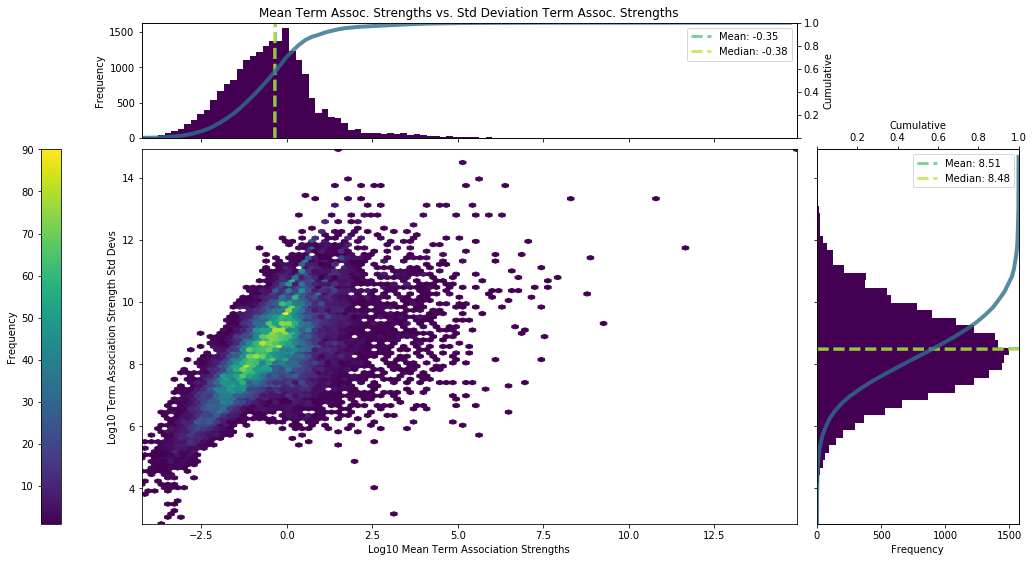

In [89]:
min_assoc_strengths, max_assoc_strengths = get_valid_arrays(terms_df, 'min_assoc_strength_log', 'max_assoc_strength_log')

hexbin_sidegrams(min_assoc_strengths, max_assoc_strengths,
                 hb_xlabel='Log10 Mean Term Association Strengths',
                 hb_ylabel='Log10 Term Association Strength Std Devs',
                 title='Mean Term Assoc. Strengths vs. Std Deviation Term Assoc. Strengths', 
                 cb_label='Frequency',
                 hb_gridsize=100,
                 lh_bins=50)

In [90]:
from pandas.plotting import scatter_matrix

In [91]:
def get_valid_df(df, cols):
    sub_df = df[cols]
    sub_df = sub_df.replace([np.inf, -np.inf], np.nan)
    for col in cols:
        sub_df = sub_df[~pd.isnull(sub_df[col])]
    return sub_df

In [92]:
terms_df_tmp = get_valid_df(terms_df, ['terms', 'occurrences_log', 'cooccurrences_log', 'edges_log', 'mean_assoc_strength_log', 'median_assoc_strength_log',
                             'std_assoc_strength_log', 'min_assoc_strength_log', 'max_assoc_strength_log'])

In [93]:
from pandas.plotting import scatter_matrix

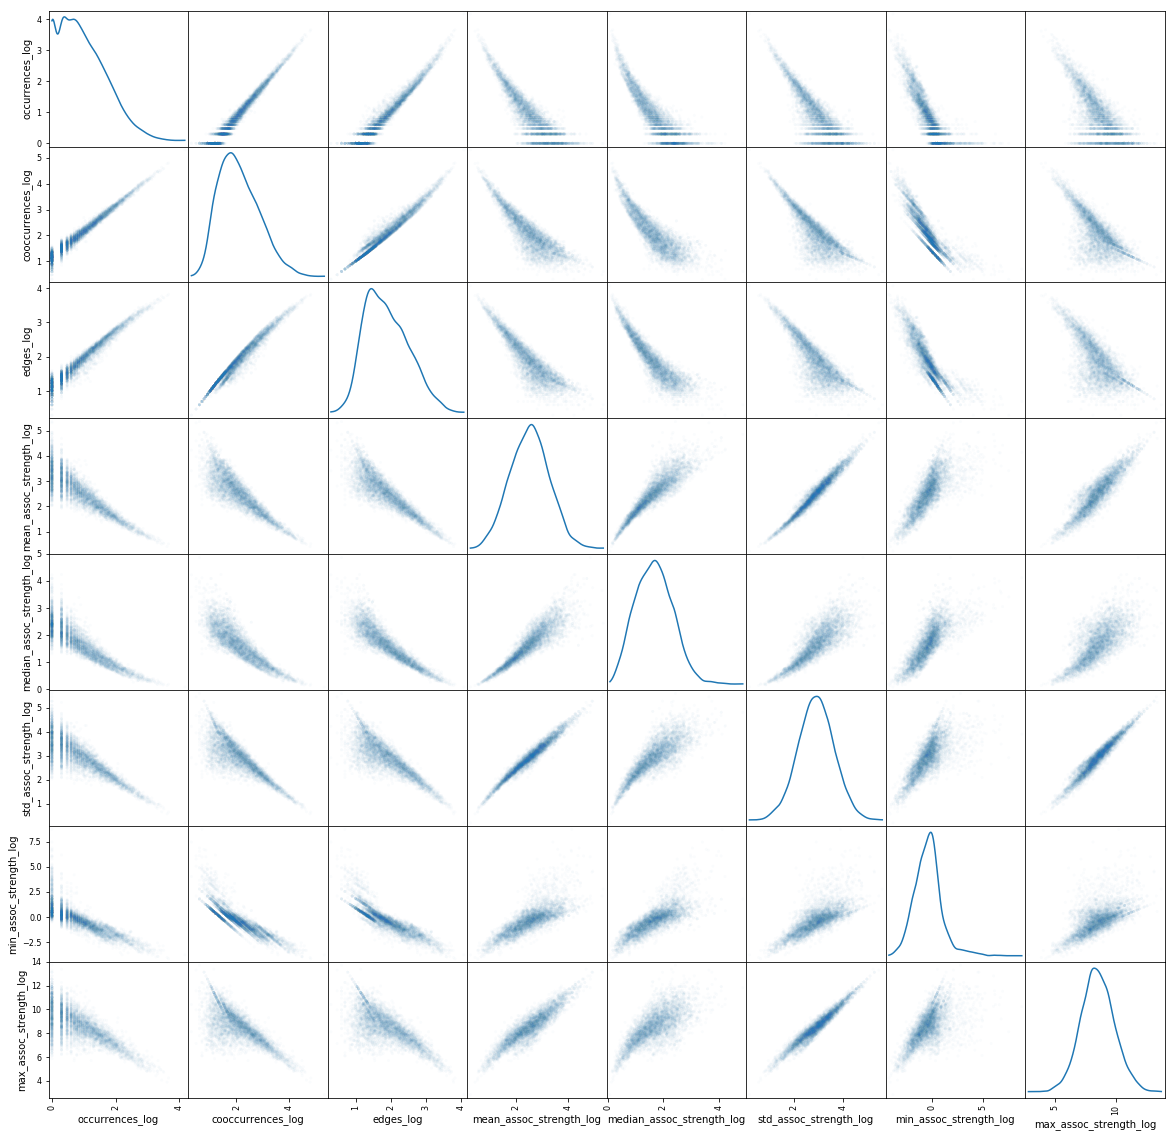

In [94]:
ax = scatter_matrix(terms_df_tmp.sample(frac=0.25, random_state=42), alpha=0.02, figsize=(20, 20), diagonal='kde')

In [95]:
from sklearn.manifold.t_sne import TSNE

In [96]:
tsne = TSNE(perplexity=10)

In [392]:
terms_tsne = tsne.fit_transform(terms_df_tmp[['occurrences_log', 'cooccurrences_log', 'edges_log', 'mean_assoc_strength_log', 'median_assoc_strength_log',
                                              'std_assoc_strength_log', 'min_assoc_strength_log', 'max_assoc_strength_log']])

In [393]:
terms_df_tmp['tsne_0'] = terms_tsne[:, 0]
terms_df_tmp['tsne_1'] = terms_tsne[:, 1]

In [394]:
cds = ColumnDataSource(terms_df_tmp)

In [399]:
from bokeh.models import BoxZoomTool, ResetTool, WheelZoomTool, LinearColorMapper

In [402]:
color_mapper = LinearColorMapper(palette='Magma256', low=min(terms_df_tmp['occurrences_log']), high=max(terms_df_tmp['occurrences_log']))

hover = HoverTool(tooltips=[
    ("Term", "@terms"),
])
box = BoxZoomTool()
reset = ResetTool()
zoom = WheelZoomTool()
# color_mapper = CategoricalColorMapper(factors=list(w2v_df['label'].values.unique()))

terms_tsne_scatter = figure(width=700, height=600, tools=[hover, box, reset, zoom],
                     title='TSNE Plot of MeSH Term Network Characteristics')
terms_tsne_scatter.circle(x='tsne_0', y='tsne_1', source=cds, alpha=0.2,
                          color={'field': 'occurrences_log', 'transform': color_mapper}
#                           color=factor_cmap('clusters_k', palette=Category20_20, factors=list(w2v_df['clusters_k'].unique())),
#                           size=6
                         )
terms_tsne_scatter.xgrid.visible = False
terms_tsne_scatter.ygrid.visible = False


show(terms_tsne_scatter)

In [98]:
descriptions[100]

'Imaging technologies are allowing us to probe the shape and function of the organs and structures that make up the human body. This can be done without harming the patient in any way. These technologies allow us to monitor treatment and guide therapies to where they are most needed. The 3D imaging techniques such as X-ray CT and MRI have only been around for 30 years yet in that time they have transformed healthcare. In recent years there have been significant advances in extending imaging methods, in particular optical techniques, to investigate the function of living cells that make up the human body and the interactions between the molecules that govern the functions of these cells. The level of detail provided by these images covers 6 orders of magnitude, often in 3D. This has created a challenge to find ways to understand how to relate relevant information across this wide range of spatial scale. This is required in order to better understand the function and interactions of the 

### Term Edges

In [440]:
term_edges_df = pd.DataFrame({'edge': list(edge_coocurrence_counts.keys())})
term_edges_df['cooccurrence_count'] = term_edges_df['edge'].map(edge_coocurrence_counts)

In [441]:
edge_list = term_edges_df['edge'].values
edge_terms_0 = [e[0] for e in edge_list]
edge_terms_1 = [e[1] for e in edge_list]

In [442]:
term_edges_df['term_0'] = edge_terms_0
term_edges_df['term_1'] = edge_terms_1

In [461]:
term_edges_df['term_occurrence_0'] = term_edges_df['term_0'].map(mesh_label_unique_counts)
term_edges_df['term_occurrence_1'] = term_edges_df['term_1'].map(mesh_label_unique_counts)
term_edges_df['term_cooccurrence_0'] = term_edges_df['term_0'].map(mesh_label_coocurrence_counts)
term_edges_df['term_cooccurrence_1'] = term_edges_df['term_1'].map(mesh_label_coocurrence_counts)

In [462]:
term_edges_df['cooccurrence_per_occurrence'] = term_edges_df['cooccurrence_count'] / (term_edges_df['term_occurrence_0'] + term_edges_df['term_occurrence_1'])

In [465]:
term_edges_df['cooccurrence_assoc_strength'] = (2 * n_coocurrences * term_edges_df['cooccurrence_count']) / (term_edges_df['term_cooccurrence_0'] * term_edges_df['term_cooccurrence_1'])

In [427]:
def map_association_strength(edge):
    edge = ast.literal_eval(edge)
    return association_strength(edge[0], edge[1], edge_coocurrence_counts[edge])

term_edges_df['assoc_strengths'] = term_edges_df['edge'].apply(lambda x: map_association_strength(str(x)))

In [215]:
term_edges_sample_df = term_edges_df.sample(frac=0.1, random_state=42)

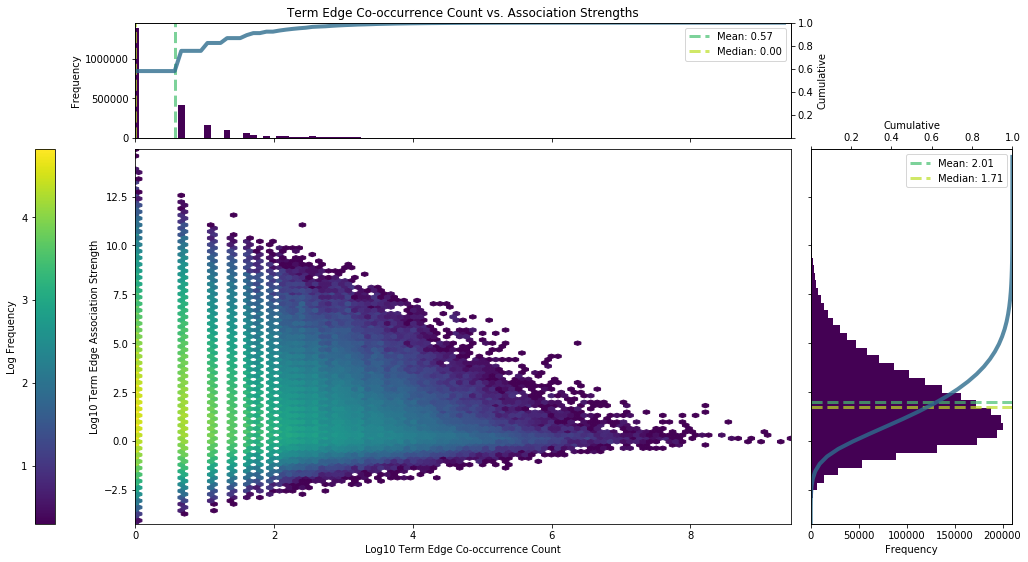

In [216]:
hexbin_sidegrams(np.log(term_edges_df['counts']), np.log(term_edges_df['assoc_strengths']),
                 hb_xlabel='Log10 Term Edge Co-occurrence Count',
                 hb_ylabel='Log10 Term Edge Association Strength',
                 title='Term Edge Co-occurrence Count vs. Association Strengths', 
                 cb_label='Log Frequency',
                 hb_gridsize=100,
                 lh_bins=50,
                 hb_bins='log')

In [217]:
edge_association_strengths = []
edge_counts = []
for edge, count in mesh_label_edges.items():
    edge_association_strengths.append(association_strength(edge[0], edge[1], mesh_label_edges[edge]))
    edge_counts.append(count)

In [218]:
edge_association_strengths_log = np.log(edge_association_strengths)
edge_counts_log = np.log(edge_counts)

In [219]:
edge_jaccard_similarities = []
for edge, count in mesh_label_edges.items():
    edge_jaccard_similarities.append(jaccard_similarity(mesh_label_unique_counts[edge[0]], mesh_label_unique_counts[edge[1]], count))

In [220]:
edge_jaccard_similarities_log = np.log(edge_jaccard_similarities)

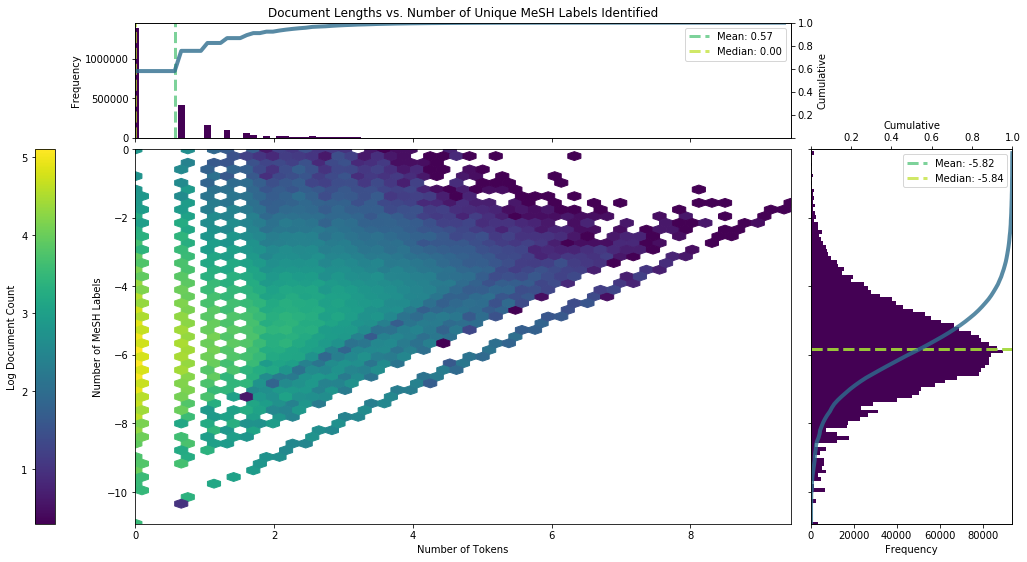

In [221]:
hexbin_sidegrams(edge_counts_log, edge_jaccard_similarities_log,
                 hb_bins='log', hb_gridsize=50,
                 hb_xlabel='Number of Tokens',
                 hb_ylabel='Number of MeSH Labels',
                 title='Document Lengths vs. Number of Unique MeSH Labels Identified', 
                 cb_label='Log Document Count'
                )

In [223]:
edge_nodes = []

for k, v in mesh_edge_counts.items():
    edge_nodes.append(v)
    
edge_node_counts = Counter(edge_nodes)    

In [224]:
pd.DataFrame({'Coocurrence Counts': edge_counts,
             'Association Strengths': edge_association_strengths,
             'Jaccard Indexes': edge_jaccard_similarities})[['Coocurrence Counts',
                                                             'Jaccard Indexes',
                                                             'Association Strengths']].describe().round()

Coocurrence Counts  Jaccard Indexes  Association Strengths
count           2392740.0        2392740.0              2392740.0
mean                  4.0              0.0                  159.0
std                  27.0              0.0                 3698.0
min                   1.0              0.0                    0.0
25%                   1.0              0.0                    2.0
50%                   1.0              0.0                    6.0
75%                   2.0              0.0                   24.0
max               12631.0              1.0              2989978.0

### Documents

In [94]:
# no new dataframe here, as we can just use the gdb_df

In [225]:
gdb_df['n_tokens'] = [len(d) for d in descriptions_tokenized]
gdb_df['n_mesh_labels'] = [len(ml) for ml in mesh_labels]
gdb_df['n_unique_mesh_labels'] = [len(list(set(ml))) for ml in mesh_labels]

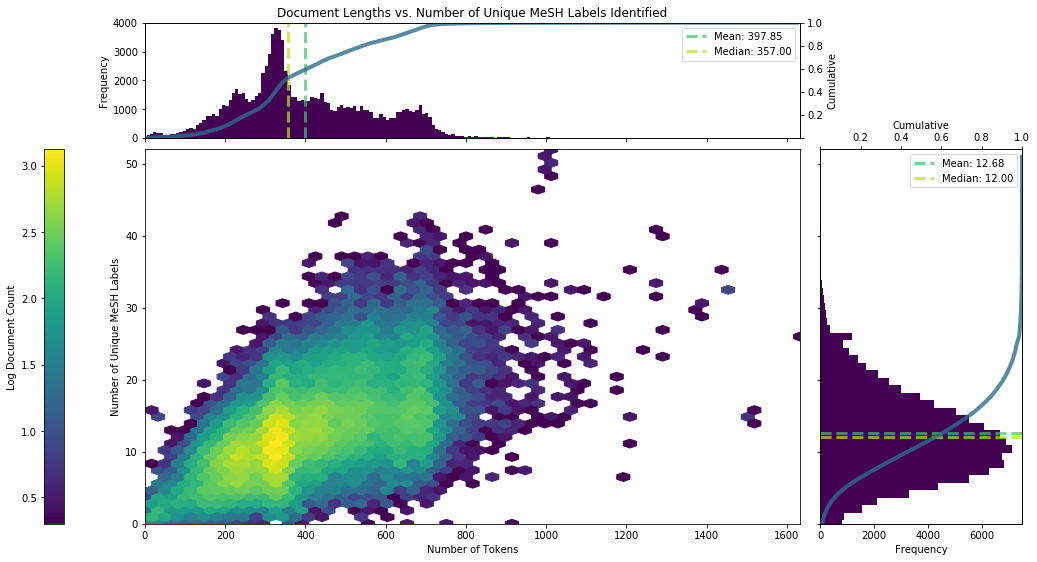

In [226]:
hexbin_sidegrams(gdb_df['n_tokens'], gdb_df['n_unique_mesh_labels'], 
                 hb_bins='log', hb_gridsize=50,
                 hb_xlabel='Number of Tokens',
                 hb_ylabel='Number of Unique MeSH Labels',
                 title='Document Lengths vs. Number of Unique MeSH Labels Identified', 
                 cb_label='Log Document Count',
                 th_bins=200,
                 lh_bins=50)

We can see that there are a large number (around 30%) of documents with less than 50 tokens and less than 10 MeSH labels. There's a roughly linear relationship between the number of tokens and the number of MeSH labels, as would be reasonable to expect, however the spread of points is very large. There vast majority of documents have less than 800 tokens or 40 labels. The table below gives exact values for the summary statistics of these distributions.

One other notable feature is that the histogram of document lengths shows a few humps at around 250, 350 and 500 tokens. Perhaps this reflects proposal or abstract word limits imposed by funding bodies.

In [102]:
gdb_df[['n_tokens', 'n_mesh_labels', 'n_unique_mesh_labels']].describe().round()

n_tokens  n_mesh_labels  n_unique_mesh_labels
count  132206.0       132206.0              132206.0
mean      301.0           18.0                  10.0
std       219.0           16.0                   7.0
min         0.0            0.0                   0.0
25%        26.0            3.0                   3.0
50%       317.0           16.0                  10.0
75%       450.0           27.0                  15.0
max      1633.0          133.0                  52.0

In [103]:
mean_doc_association_strength = []
median_doc_association_strength = []
stddev_doc_association_strength = []
for mlc in mesh_label_coocurrences:
    association_strengths = [association_strength(edge[0], edge[1], mesh_label_edges[edge]) for edge in mlc]
    if len(association_strengths) > 0:
        mean_doc_association_strength.append(np.mean(association_strengths))
        median_doc_association_strength.append(np.median(association_strengths))
        if len(association_strengths) > 1:
            stddev_doc_association_strength.append(np.std(association_strengths))
        else:
            stddev_doc_association_strength.append(np.nan)
    else:
        mean_doc_association_strength.append(np.nan)
        median_doc_association_strength.append(np.nan)
        stddev_doc_association_strength.append(np.nan)

In [104]:
gdb_df['mean_assoc_strengths_unique_mesh_label'] = mean_doc_association_strength
gdb_df['median_assoc_strengths_unique_mesh_label'] = median_doc_association_strength
gdb_df['std_assoc_strengths_unique_mesh_label'] = stddev_doc_association_strength

In [105]:
mean, std = get_valid_arrays(gdb_df, 'mean_assoc_strengths_unique_mesh_label', 'std_assoc_strengths_unique_mesh_label')
mean, std = (np.log(mean), np.log(std))

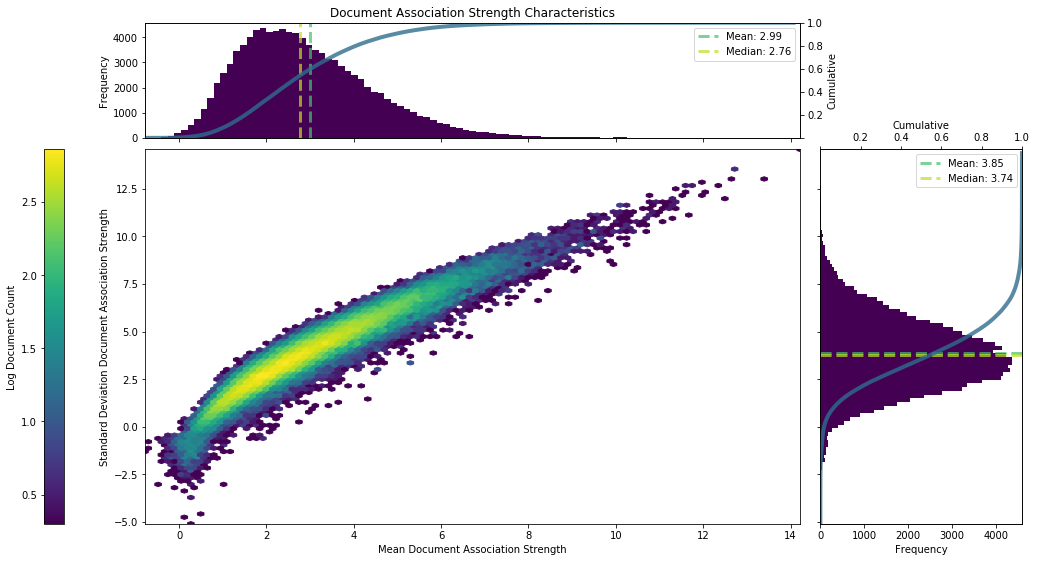

In [107]:
hexbin_sidegrams(mean, std,
                 hb_bins='log', hb_gridsize=100,
                 hb_xlabel='Mean Document Association Strength',
                 hb_ylabel='Standard Deviation Document Association Strength',
                 title='Document Association Strength Characteristics', 
                 cb_label='Log Document Count'
                )

In [159]:
gdb_df[gdb_df['mean_assoc_strengths_unique_mesh_label'] < 1]['Description'].iloc[400]

'AMERICANA INSURANCE SERVICES is a provider of insurance coverage for protecting auto, home, business, farm, crops, health, life, and family.'

In [ ]:
mesh_label_uniques = [list(set(ml)) for ml in mesh_labels]

In [ ]:
mesh_label_uniques_joined = [' '.join([s.replace(', ', '_').replace(' ', '_') for s in ml]) for ml in mesh_label_uniques]

In [955]:
from sklearn.feature_extraction.text import CountVectorizer

In [956]:
cv = CountVectorizer()

In [957]:
docs_bow = cv.fit_transform(mesh_label_uniques_joined)

In [984]:
docs_bow_sums = np.array(docs_bow.sum(axis=0).tolist()[0])

In [985]:
for i, n in enumerate(docs_bow_sums):
    

array([  2, 159,   5, ...,  61,   2,   2])

In [971]:
np.matrix.sum(np.matrix([[1,2,3], [1,2,3], [1,2,3]]), axis=0)

matrix([[3, 6, 9]])

In [962]:
a = docs_bow[0]

In [966]:
np.sum(a.toarray())

12

In [960]:
docs_bow_df = pd.DataFrame(docs_bow)

ValueError: DataFrame constructor not properly called!

In [336]:
edge_node_counts_x = []
edge_node_counts_y = []

for k, v in edge_node_counts.items():
    edge_node_counts_x.append(k)
    edge_node_counts_y.append(v)

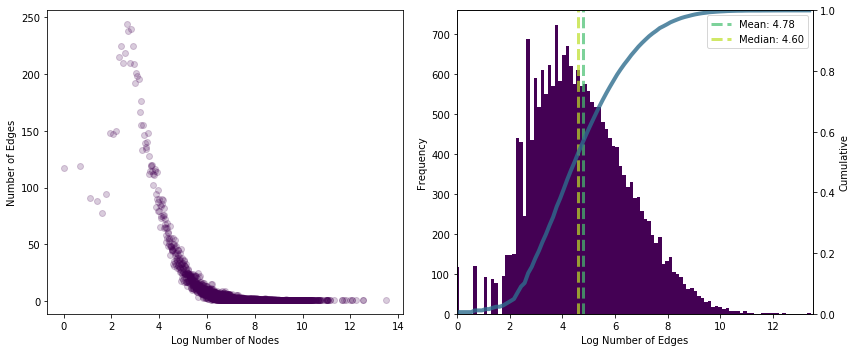

In [841]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))

ax0.scatter(np.log(edge_node_counts_x), edge_node_counts_y, color=plt.get_cmap('viridis').colors[0], alpha=0.2)
ax0.set_xlabel('Log Number of Nodes')
ax0.set_ylabel('Number of Edges')
pdf_cdf(ax1, np.log(edge_nodes), 100, normed=False)
ax1.set_xlabel('Log Number of Edges')
plt.tight_layout()
plt.show()

In [353]:
from networkx.algorithms import community

In [354]:
communities_generator = community.girvan_newman(graph_mesh_labels)

In [ ]:
for edge, count in mesh_label_edges.items():

In [573]:
mean_doc_association_strength = [0 if pd.isnull(a) else a for a in mean_doc_association_strength ]

In [281]:
mesh_label_counts['Nutrition Policy']

146

In [272]:
nutrition_policy_neighbours = list(graph_mesh_labels.neighbors('Nutrition Policy'))

In [273]:
mental_processes_neighbours = list(graph_mesh_labels.neighbors('Mental Processes'))

In [291]:
sub_nodes = list(set(nutrition_policy_neighbours + mental_processes_neighbours))
sub_nodes = [sn for sn in sub_nodes if mesh_label_counts[sn] > 2]

In [301]:
with open(proc_data + 'mental_processes_nutrition_policy_graph.json', 'w') as f:
    json.dump(nx.node_link_data(sub_graph), f)

In [306]:
df = nx.to_pandas_adjacency(sub_graph, weight='association_strength')

In [304]:
import seaborn as sns

In [312]:
df_log = np.log(df)
df_log[np.isinf(df_log)] = 0

/Users/grichardson/miniconda3/envs/rwjf/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


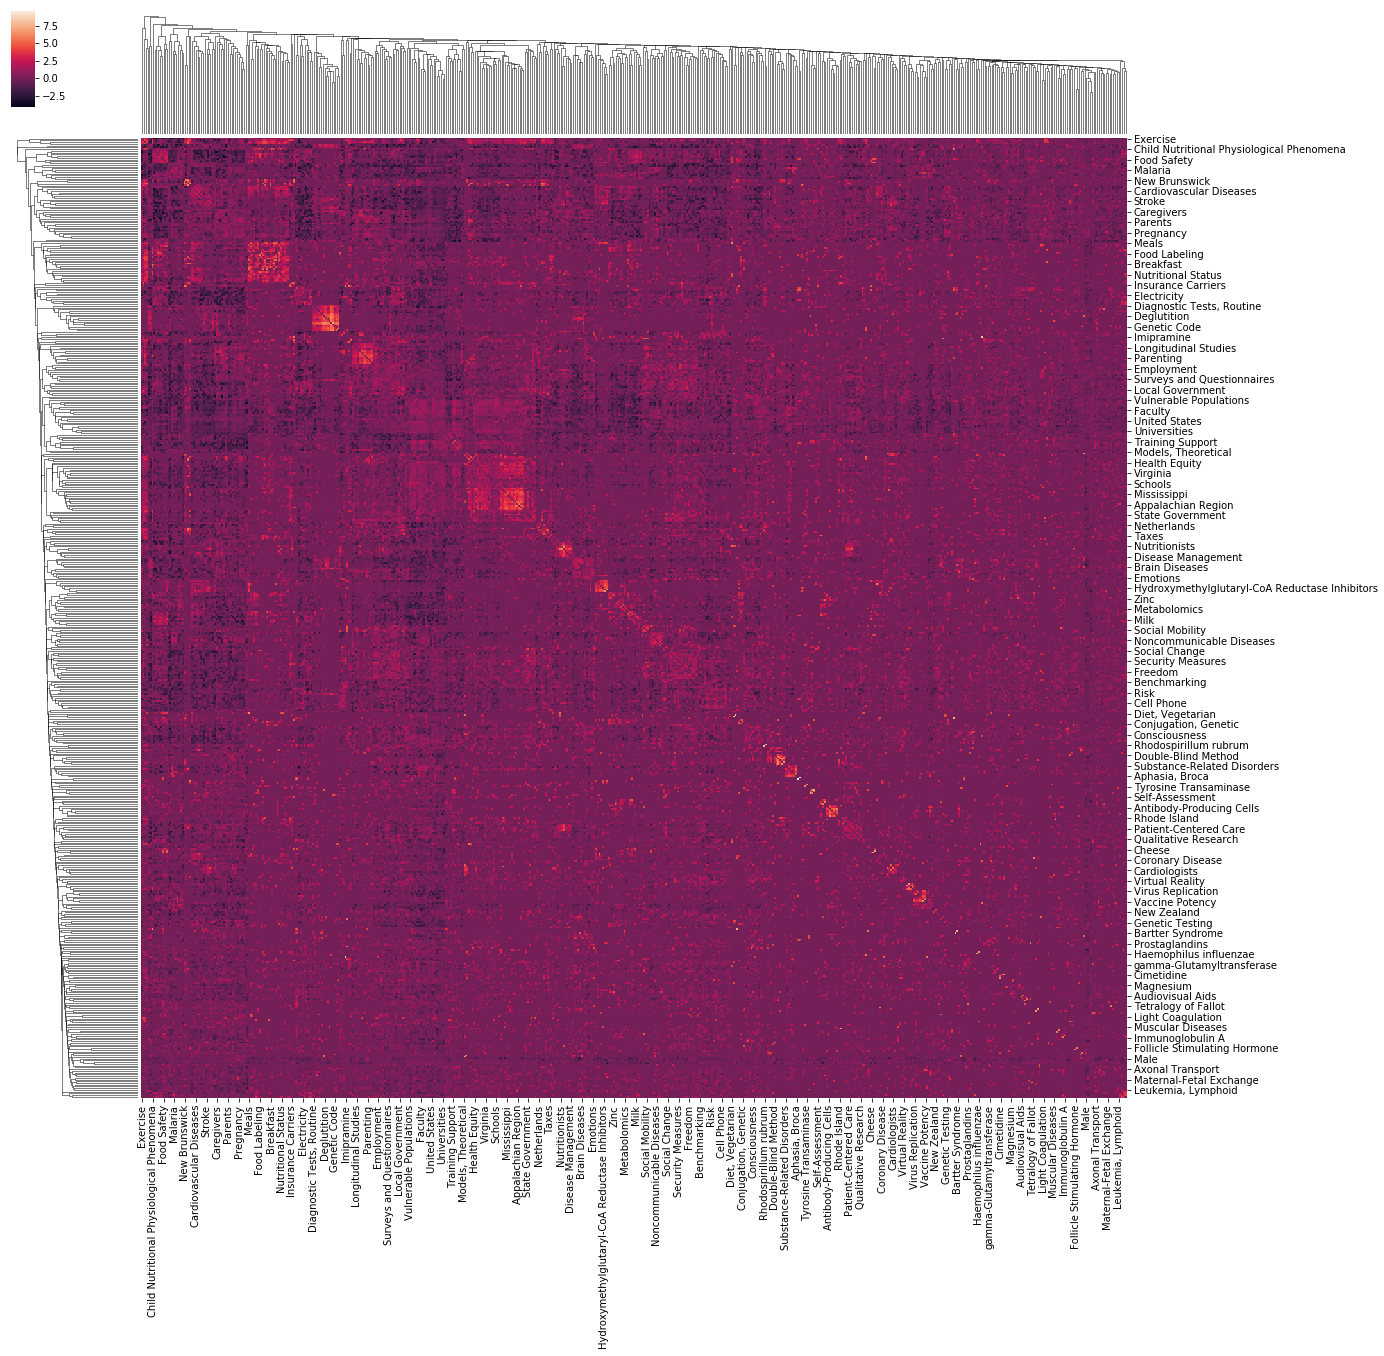

In [317]:
sns.clustermap(df_log, figsize=(20,20))